## Organ Segmentation

#### *Table of Contents*
1. [CT Image](#chapter1)
2. [Images preprocessing - DICOM & MONAI](#chapter2)
2. [MONAI preprocessing pipeline](#chapter3)
3. [Segmentation model](#chapter4)
4. [Inference settings](#chapter5)
5. [Postprocessing](#chapter6)
6. [Prediction](#chapter7)

- libraries

In [1]:
import numpy as np
import os
import torch
import pydicom
import json
import monai
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder

d:\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


- CT image

In [3]:
cart_name = "nbia-56981726416364353"
cart_data = nbia.getSharedCart(cart_name)
df = nbia.downloadSeries(cart_data, format="df", path = "..data/body_scan")

2024-09-15 18:08:03,367:INFO:Success - Token saved to api_call_headers variable and expires at 2024-09-15 20:08:03.367327
2024-09-15 18:08:03,369:INFO:Accessing public data anonymously. To access restricted data use nbia.getToken() with your credentials.
2024-09-15 18:08:03,370:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v2/getContentsByName with parameters {'name': 'nbia-56981726416364353'}
2024-09-15 18:08:04,561:INFO:Downloading 1 out of 1 Series Instance UIDs (scans).
2024-09-15 18:08:04,561:INFO:Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v2/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668
2024-09-15 18:09:15,462:INFO:Downloaded 1 out of 1 Series Instance UIDs (scans).
0 failed to download.
0 previously downloaded.


In [21]:
ct_data = os.path.join(os.getcwd(), "ct_data/body_scan_1")

- DICOM:

In [21]:
ds = pydicom.read_file(os.path.join(ct_data, '1-390.dcm'))

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.3320.3273.147563408875124767580318944551
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'OTHER']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID      

In [23]:
img = ds.pixel_array
img.shape

(512, 512)

In [25]:
# ADJUSTING FORMAT
img_scaled = ds.RescaleSlope * img + ds.RescaleIntercept
img_scaled

array([[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       ...,
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.]])

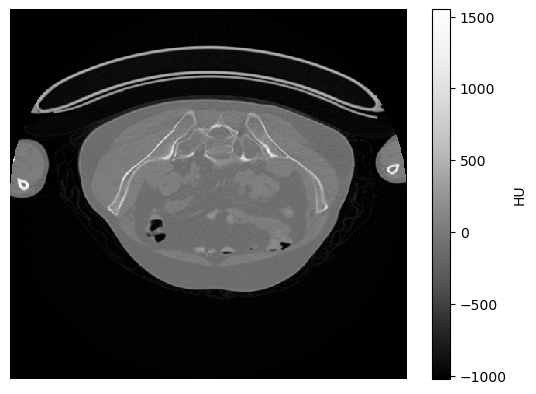

In [26]:
plt.pcolormesh(img_scaled, cmap='Greys_r')
plt.colorbar(label='HU') # Hounsfield units (~ -1000== air; 0==water, +1000==bone)
plt.axis('off')
plt.show()

# IMPORTANT: images needs to be sortedss

- MONAI:

In [22]:
img_loader = LoadImage(image_only=True)
CT = img_loader(ct_data) # folder with all dicoms
CT # metatensor

metatensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         ...,
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],

        [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         ...,
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],

        [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024.

In [23]:
CT.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e

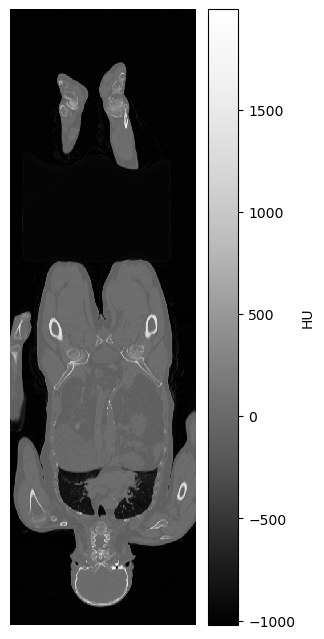

In [24]:
CT_coronal_slice = CT[:,256].cpu().numpy()

plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU') 
plt.axis('off')
plt.show()

In [25]:
CT.shape

torch.Size([512, 512, 975])

In [26]:
# adding fisrt channel
channel_transform = EnsureChannelFirst()
CT = channel_transform(CT)
CT.shape

torch.Size([1, 512, 512, 975])

In [27]:
# orientation
orientation_transform = Orientation(axcodes=('LPS'))  # Left, Posterior, Superior

In [28]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" ### ignore duplication of OpenMP libraries

In [29]:
CT = orientation_transform(CT)

In [30]:
CT_coronal_slice = CT[0,:,256].cpu().numpy()

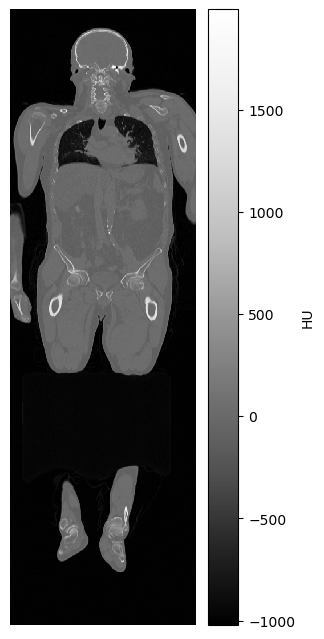

In [31]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

- preprocessing MONAI pipeline

In [36]:
preprocess_pipeline = Compose({
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes='LPS')
})

In [37]:
ct_scan = preprocess_pipeline(ct_data)

d:\anaconda3\Lib\site-packages\monai\transforms\io\array.py:255: UserWarning: Failed to read d:\Studia\Kursy notatki\Projects\AI Health platform\AI-Health-Check\notebooks\ct_data\body_scan_1\LICENSE with exception: 
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading..
  img = reader.read(filename)


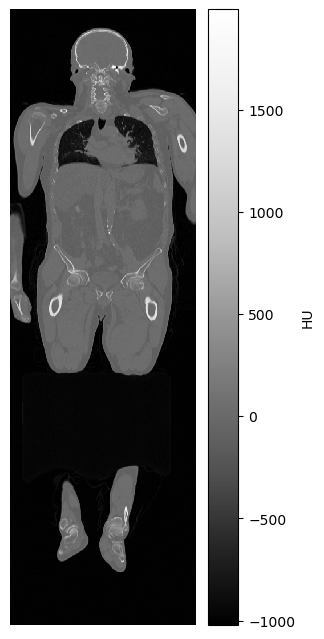

In [38]:
ct_coronal_slice = ct_scan[0, : ,256].cpu().numpy()

plt.figure(figsize=(3,8))
plt.pcolormesh(ct_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

- dictionary version of pipeline

In [50]:
ct_data = os.path.join(os.getcwd(), "ct_data/body_scan_1")

In [51]:
data = {'image': ct_data, 'other_key': 42}
data

{'image': 'd:\\Studia\\Kursy notatki\\Projects\\AI Health platform\\AI-Health-Check\\notebooks\\ct_data/body_scan_1',
 'other_key': 42}

In [52]:
preprocess_pipeline = Compose({
    LoadImaged(keys='image', image_only=True),
    EnsureChannelFirstd(keys='image'),
    Orientationd(keys='image', axcodes='LPS')
})

In [53]:
data = preprocess_pipeline(data)
data # metatensor

d:\anaconda3\Lib\site-packages\monai\transforms\io\array.py:255: UserWarning: Failed to read d:\Studia\Kursy notatki\Projects\AI Health platform\AI-Health-Check\notebooks\ct_data\body_scan_1\LICENSE with exception: 
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading..
  img = reader.read(filename)


{'image': metatensor([[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           

- Segmentation Model ([MONAI zoo](https://monai.io/model-zoo.html))

In [56]:
model_name = 'wholeBody_ct_segmentation'
download(name = model_name, bundle_dir="../models")

2024-09-15 20:07:13,630 - INFO - --- input summary of monai.bundle.scripts.download ---
2024-09-15 20:07:13,631 - INFO - > name: 'wholeBody_ct_segmentation'
2024-09-15 20:07:13,631 - INFO - > bundle_dir: '../models'
2024-09-15 20:07:13,632 - INFO - > source: 'monaihosting'
2024-09-15 20:07:13,633 - INFO - > remove_prefix: 'monai_'
2024-09-15 20:07:13,634 - INFO - > progress: True
2024-09-15 20:07:13,634 - INFO - ---




wholeBody_ct_segmentation_v0.2.5.zip: 133MB [00:09, 14.9MB/s]                              


2024-09-15 20:07:24,426 - INFO - Downloaded: ..\models\wholeBody_ct_segmentation_v0.2.5.zip
2024-09-15 20:07:24,427 - INFO - Expected md5 is None, skip md5 check for file ..\models\wholeBody_ct_segmentation_v0.2.5.zip.
2024-09-15 20:07:24,428 - INFO - Writing into directory: ..\models.


In [63]:
# model path & inference.json path
model_path = os.path.join(os.getcwd(), '../models/wholeBody_ct_segmentation/models/model_lowres.pt')
config_path = os.path.join(os.getcwd(), '../models/wholeBody_ct_segmentation/configs/inference.json')

In [64]:
config = ConfigParser()
config.read_config(config_path)
config

{'_meta_': {}, 'displayable_configs': {'highres': False, 'sw_overlap': 0.25, 'sw_batch_size': 1}, 'imports': ['$import glob', '$import numpy', '$import os'], 'bundle_root': '.', 'image_key': 'image', 'output_dir': "$'D:/Studia/Kursy notatki/Projects/AI Health platform/AI-Health-Check/data/body_scan/mask'", 'output_ext': '.nii.gz', 'output_dtype': '$numpy.float32', 'output_postfix': 'trans', 'separate_folder': True, 'load_pretrain': True, 'dataset_dir': 'sampledata', 'datalist': "$list(sorted(glob.glob(@dataset_dir + '/imagesTs/*.nii.gz')))", 'device': "$'cpu'", 'pixdim': '$[1.5, 1.5, 1.5] if @displayable_configs::highres else [3.0, 3.0, 3.0]', 'modelname': "$'model.pt' if @displayable_configs::highres else 'model_lowres.pt'", 'network_def': {'_target_': 'SegResNet', 'spatial_dims': 3, 'in_channels': 1, 'out_channels': 105, 'init_filters': 32, 'blocks_down': [1, 2, 2, 4], 'blocks_up': [1, 1, 1], 'dropout_prob': 0.2}, 'network': '$@network_def.to(@device)', 'preprocessing': {'_target_': 

- preprocessing pipeline definition

In [65]:
preprocessing_pipeline = config.get_parsed_content("preprocessing") # accept dictonaries

In [66]:
ct_data = os.path.join(os.getcwd(), "ct_data/body_scan_1")

In [68]:
data = preprocessing_pipeline({'image': ct_data})

d:\anaconda3\Lib\site-packages\monai\transforms\io\array.py:255: UserWarning: Failed to read d:\Studia\Kursy notatki\Projects\AI Health platform\AI-Health-Check\notebooks\ct_data\body_scan_1\LICENSE with exception: 
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading..
  img = reader.read(filename)


In [69]:
data # make sure data are normalized

{'image': metatensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          ...,
 
          [[-1., -1., -1.,  ...

In [70]:
model = config.get_parsed_content("network") # random params by now

- loading parameters and evaluation mode

In [76]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

C:\Users\adaml\AppData\Local\Temp\ipykernel_3136\1743700293.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=tor

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

- Inference

In [78]:
data['image'].shape 

torch.Size([1, 167, 167, 650])

In [79]:
inferer = config.get_parsed_content("inferer") # breaks data into chunks before sending to model

- Postprocessing

In [80]:
postprocessing = config.get_parsed_content("postprocessing")

- Prediction

In [81]:
# DATA 
ct_data = os.path.join(os.getcwd(), "ct_data/body_scan_1")

# PREPROCESSING
data = preprocessing_pipeline({'image': ct_data}) 

# COMPUTING PREDICTION MASK
with torch.no_grad(): # no backpropagation
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model) # added batch dimension 

# remove batch dimension
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]

# POSTPROCESSING
data = postprocessing(data)

# SEGMENTATION
segmentation = torch.flip(data['pred'][0], dims=[2])

d:\anaconda3\Lib\site-packages\monai\transforms\io\array.py:255: UserWarning: Failed to read d:\Studia\Kursy notatki\Projects\AI Health platform\AI-Health-Check\notebooks\ct_data\body_scan_1\LICENSE with exception: 
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading..
  img = reader.read(filename)


2024-09-15 20:50:32,272 INFO image_writer.py:197 - writing: D:\Studia\Kursy notatki\Projects\AI Health platform\AI-Health-Check\data\body_scan\mask\body_scan_1\body_scan_1_trans.nii.gz


AttributeError: 'builtin_function_or_method' object has no attribute 'numpy'

In [82]:
segmentation

metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 

In [83]:
segmentation = segmentation.cpu().numpy()

In [84]:
segmentation

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [85]:
segmentation.shape

(512, 512, 975)

In [95]:
SLICE_IDX = 256

CT_coronal_slice = CT[0,:,SLICE_IDX].cpu().numpy()

segmentation_coronal_slice = segmentation[:,SLICE_IDX]

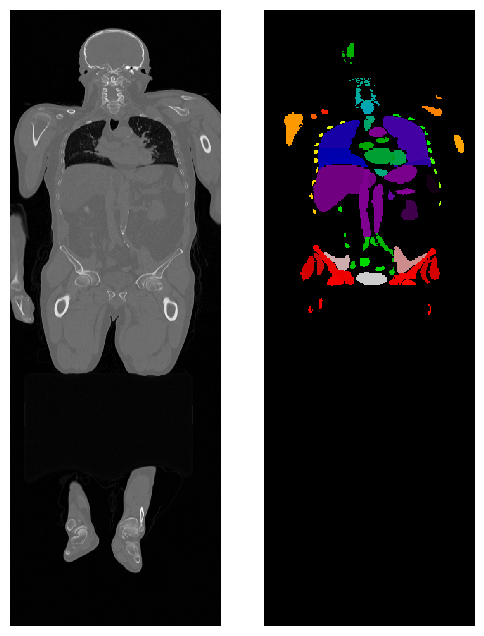

In [96]:
plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off')
plt.show()

In [97]:
CT.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[ -0.9766,   0.0000,   0.0000, 249.5117],
         [  0.0000,  -0.9766,   0.0000, 401.0117],
         [  0.0000,   0.0000,   2.0000, -11.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64),
 origi

In [98]:
number_bladder_voxels = (segmentation==104).sum().item() # get total number of voxels
voxel_volume_cm3 = np.prod(CT.meta['spacing']/10) # get cm
bladder_volume = number_bladder_voxels * voxel_volume_cm3
print(f'Bladder Volume {bladder_volume:.1f}cm^3')

Bladder Volume 142.6cm^3


In [99]:
# Tworzenie pierwszego wykresu
plt.figure(figsize=(6, 8))

# Pierwszy obrazek
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.savefig('CT_coronal_slice.png', bbox_inches='tight', pad_inches=0)

# Drugi obrazek
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off')
plt.savefig('segmentation_coronal_slice.png', bbox_inches='tight', pad_inches=0)

plt.close()  # Zamknięcie figur
